In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['active', 'inactive']
    
    output_models = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        output_models.append(clf)
        
    final = pd.concat(dfs, ignore_index=True)
    return final, output_models

### No max. registered user filter >= 3 Days Old

In [71]:
import psycopg2
import databases.snowflake as snow


q1 = f'''
WITH workspace     AS (
    SELECT
        s.server_id
      , s.first_active_date
      , s.max_active_user_count                                     AS max_daily_active_user_count
      , s.last_mm2_telemetry_date
      , s.max_registered_users
      , s.max_registered_deactivated_users
      , s.days_active::FLOAT / (s.days_active + s.days_inactive)::FLOAT AS pct_active
      , s.days_active + s.days_inactive                               AS total_days
      , s.posts_events_alltime
      , s.invite_members_alltime
      , s.signup_email_events_alltime
      , s.admin_events_alltime
      , s.tutorial_events_alltime
      , s.signup_events_alltime
      , s.slash_commands
      , s.direct_message_channels
      , s.public_channels
      , s.private_channels
      , s.incoming_webhooks
      , s.outgoing_webhooks
      , s.bot_accounts
      , s.guest_accounts
      , s.teams
      , s.mobile_events_alltime
      , s.events_alltime
      , SPLIT_PART(lsf.license_email, '@', 2) AS email_domain
    FROM ANALYTICS.mattermost.server_fact                  s
         LEFT JOIN ANALYTICS.mattermost.excludable_servers es
                   ON s.server_id = es.server_id
         LEFT JOIN ANALYTICS.BLP.LICENSE_SERVER_FACT lsf
                   ON s.server_id = lsf.server_id
                   AND lsf.license_retired_date >= CURRENT_DATE
    WHERE es.reason IS NULL
      AND s.installation_id IS NOT NULL
       AND s.max_registered_users >= 3
      AND days_active + days_inactive >= 3
                      ),
                      
     time_to_threshold as (
     select server_daily_details_ext.server_id, datediff(day, MIN(date), MIN(IFF(SERVER_DAILY_DETAILS_EXT.registered_users >= 3, DATE, NULL))) AS DAYS_TO_REGISTERED_USERS
    from ANALYTICS.mattermost.server_daily_details_ext
    join workspace
    on workspace.server_id = server_daily_details_ext.server_id
    group by 1),

     post_users    AS (
         SELECT
             server_id
           , count(DISTINCT user_actual_id) AS post_users
           , COALESCE(COUNT(DISTINCT IFF(w.first_active_date = e.timestamp::date, e.id, null))/
               NULLIF(COUNT(DISTINCT IFF(w.first_active_date = e.timestamp::date, e.USER_ACTUAL_ID, null)),0),0) as events_per_user_first_day
           , COALESCE(COUNT(DISTINCT IFF(w.first_active_date + INTERVAL '1 DAY' = e.timestamp::date, e.id, null))/
               NULLIF(COUNT(DISTINCT IFF(w.first_active_date + INTERVAL '1 DAY' = e.timestamp::date, e.id, null)),0),0) as events_per_user_second_day
         FROM workspace                         w
              JOIN ANALYTICS.events.user_events_telemetry e
                   ON w.server_id = TRIM(COALESCE(e.user_id, e.context_server, e.context_traits_server))
              --WHERE coalesce(e.type, e.event) = 'api_posts_create'
         GROUP BY 1
--          HAVING count(DISTINCT user_actual_id) >= 3
     ),

     incident_mgmt AS (
         SELECT
             w.server_id
           , count(DISTINCT im.id)                AS incident_mgmt_events
           , IFF(COUNT(DISTINCT im.id) > 0, 1, 0) AS used_incident_mgmt
         FROM workspace                            w
              JOIN ANALYTICS.events.incident_response_events im
                   ON w.server_id = im.user_id
         GROUP BY 1
     ),

     plugins       AS (
         SELECT
             w.server_id
           , count(DISTINCT p.id)                AS plugin_events
           , IFF(COUNT(DISTINCT p.id) > 0, 1, 0) AS used_plugins
         FROM workspace                 w
              JOIN ANALYTICS.events.plugin_events p
                   ON w.server_id = p.user_id
         GROUP BY 1
     )

SELECT
    COALESCE(post_users.post_users, 0)                                    AS total_active_users
  , COALESCE(post_users.events_per_user_first_day, 0)::float as events_per_user_first_day
  , COALESCE(post_users.events_per_user_second_day, 0)::float as events_per_user_second_day
  , workspace.*
  , CASE WHEN enabled_plugins - 3 < 0 THEN 0 ELSE enabled_plugins - 3 END AS enabled_plugins
  , ext.disabled_plugins
  , COALESCE(im.incident_mgmt_events, 0)                                  AS incident_mgmt_events
  , COALESCE(im.used_incident_mgmt, 0)                                    AS used_incident_mgmt
  , COALESCE(p.plugin_events, 0)                                          AS plugin_events
  , COALESCE(p.used_plugins, 0)                                           AS used_plugins
  , COALESCE(T.days_to_registered_users,0 ) AS days_to_registered_users
  , CASE WHEN pd.domain_name is not null then 0 ELSE 1 END AS private_domain
FROM workspace
     LEFT JOIN post_users
               ON post_users.server_id = workspace.server_id
     JOIN ANALYTICS.mattermost.server_daily_details_ext ext
          ON workspace.server_id = ext.server_id
              AND workspace.last_mm2_telemetry_date = ext.date
     LEFT JOIN TIME_TO_THRESHOLD T
         ON workspace.server_id = T.server_id
     LEFT JOIN incident_mgmt                  im
               ON workspace.server_id = im.server_id
     LEFT JOIN plugins                        p
               ON workspace.server_id = p.server_id
     LEFT JOIN ANALYTICS.UTIL.PUBLIC_DOMAINS pd
               ON trim(workspace.email_domain) = trim(pd.domain_name);
'''

df = snow.execute(q1, as_df = True)

In [72]:
df = df.dropna()

In [73]:
df.describe()

,TOTAL_ACTIVE_USERS,EVENTS_PER_USER_FIRST_DAY,EVENTS_PER_USER_SECOND_DAY,MAX_DAILY_ACTIVE_USER_COUNT,MAX_REGISTERED_USERS,MAX_REGISTERED_DEACTIVATED_USERS,PCT_ACTIVE,TOTAL_DAYS,POSTS_EVENTS_ALLTIME,INVITE_MEMBERS_ALLTIME,...,MOBILE_EVENTS_ALLTIME,EVENTS_ALLTIME,ENABLED_PLUGINS,DISABLED_PLUGINS,INCIDENT_MGMT_EVENTS,USED_INCIDENT_MGMT,PLUGIN_EVENTS,USED_PLUGINS,DAYS_TO_REGISTERED_USERS,PRIVATE_DOMAIN
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.00000,225.000000,225.000000,225.000000
mean,3.822222,84.319418,0.675556,3.622222,8.902222,0.231111,0.236675,48.528889,169.133333,5.191111,...,47.635556,2127.786667,0.466667,0.431111,1.266667,0.071111,0.32000,0.080000,3.404444,0.697778
std,2.012116,87.075003,0.469211,1.551049,68.607835,1.210044,0.203130,25.724160,1102.934463,8.103896,...,191.964493,5434.295331,1.056443,1.020290,8.295330,0.257583,1.73071,0.271898,7.841680,0.460245
min,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.011364,4.000000,0.000000,0.000000,...,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,3.000000,38.500000,0.000000,3.000000,3.000000,0.000000,0.083333,29.000000,3.000000,1.000000,...,0.000000,307.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,3.000000,61.666667,1.000000,3.000000,4.000000,0.000000,0.166667,47.000000,13.000000,3.000000,...,0.000000,794.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,4.000000,103.600000,1.000000,4.000000,5.000000,0.000000,0.344828,60.000000,42.000000,7.000000,...,26.000000,2044.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,1.000000
max,16.000000,847.500000,1.000000,11.000000,1033.000000,12.000000,0.917647,238.000000,14934.000000,93.000000,...,1964.000000,62134.000000,7.000000,5.000000,99.000000,1.000000,20.00000,1.000000,49.000000,1.000000


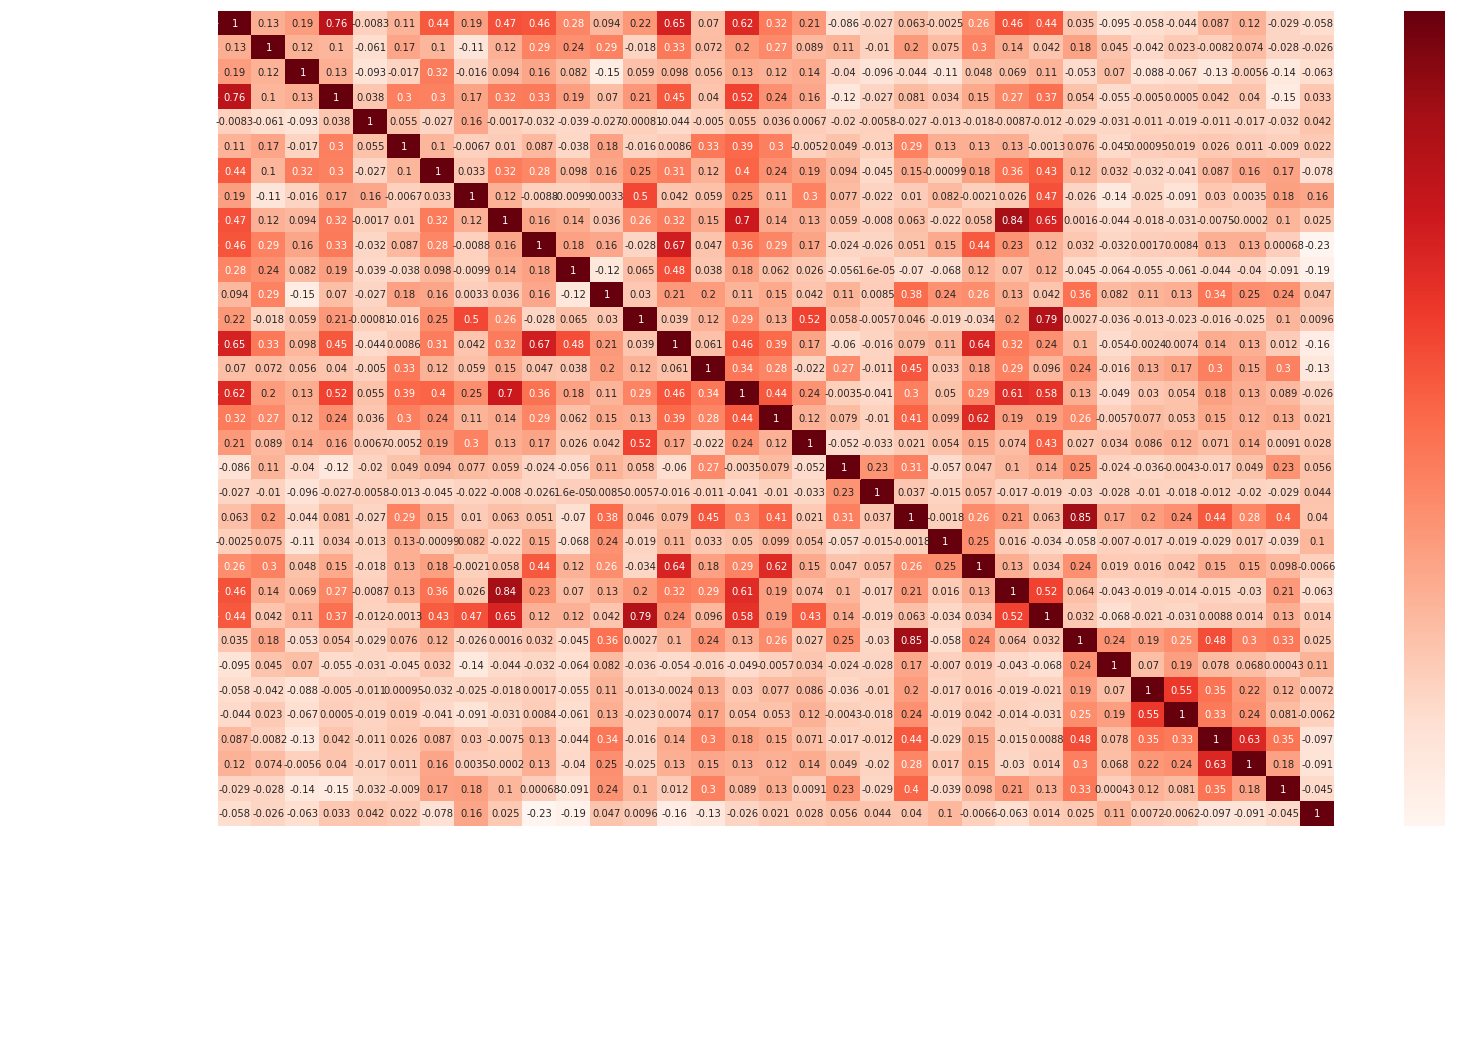

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [48]:
df2 = df.copy()

In [49]:
X = df.drop(['SERVER_ID', 'FIRST_ACTIVE_DATE', 'LAST_MM2_TELEMETRY_DATE', 'PCT_ACTIVE', 'EMAIL_DOMAIN'
#               'MAX_REGISTERED_USERS', 'GUEST_ACCOUNTS',
#              'MAX_REGISTERED_DEACTIVATED_USERS', 'MAX_DAILY_ACTIVE_USER_COUNT', 'TOTAL_ACTIVE_USERS',
#               'DIRECT_MESSAGE_CHANNELS',
#              'POSTS_EVENTS_ALLTIME'
            ], axis = 1)

In [50]:
df2['target'] = (df2['PCT_ACTIVE'] >= .8)
y = df2['target']

In [51]:
df2[df2['target'] == True].describe()

,TOTAL_ACTIVE_USERS,EVENTS_PER_USER_FIRST_DAY,EVENTS_PER_USER_SECOND_DAY,MAX_DAILY_ACTIVE_USER_COUNT,MAX_REGISTERED_USERS,MAX_REGISTERED_DEACTIVATED_USERS,PCT_ACTIVE,TOTAL_DAYS,POSTS_EVENTS_ALLTIME,INVITE_MEMBERS_ALLTIME,...,OUTGOING_WEBHOOKS,BOT_ACCOUNTS,GUEST_ACCOUNTS,ENABLED_PLUGINS,DISABLED_PLUGINS,INCIDENT_MGMT_EVENTS,USED_INCIDENT_MGMT,PLUGIN_EVENTS,USED_PLUGINS,DAYS_TO_REGISTERED_USERS
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.000000,103.000000,103.000000,103.000000,103.00000,103.000000,103.00000,103.000000,103.000000,103.000000
mean,33.165049,106.874159,0.854369,11.087379,37.213592,0.669903,0.925633,49.864078,3529.135922,29.417476,...,0.009709,3.951456,0.310680,0.893204,0.68932,2.776699,0.07767,4.174757,0.427184,2.699029
std,245.229268,81.078551,0.354461,47.411239,298.917480,2.088194,0.085912,36.304823,9301.090688,173.451159,...,0.098533,1.430608,1.204804,1.327777,1.48211,20.640685,0.26896,16.705891,0.497088,5.999730
min,3.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.800000,4.000000,1.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,5.000000,49.500000,1.000000,4.000000,4.000000,0.000000,0.857983,28.000000,214.500000,3.000000,...,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,6.000000,83.333333,1.000000,5.000000,6.000000,0.000000,0.920000,43.000000,686.000000,6.000000,...,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,9.000000,142.916667,1.000000,7.000000,8.000000,0.000000,1.000000,61.500000,2709.000000,13.000000,...,0.000000,4.000000,0.000000,1.500000,1.00000,0.000000,0.00000,2.000000,1.000000,3.000000
max,2494.000000,402.000000,1.000000,479.000000,3039.000000,15.000000,1.250000,238.000000,63405.000000,1749.000000,...,1.000000,9.000000,9.000000,6.000000,9.00000,202.000000,1.00000,156.000000,1.000000,49.000000


df2['target'] = (df2['POSTS_EVENTS_ALLTIME'] >= 1000)
y = df2['target']

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8675309)

In [54]:
X_train

,TOTAL_ACTIVE_USERS,EVENTS_PER_USER_FIRST_DAY,EVENTS_PER_USER_SECOND_DAY,MAX_DAILY_ACTIVE_USER_COUNT,MAX_REGISTERED_USERS,MAX_REGISTERED_DEACTIVATED_USERS,TOTAL_DAYS,POSTS_EVENTS_ALLTIME,INVITE_MEMBERS_ALLTIME,SIGNUP_EMAIL_EVENTS_ALLTIME,...,BOT_ACCOUNTS,GUEST_ACCOUNTS,ENABLED_PLUGINS,DISABLED_PLUGINS,INCIDENT_MGMT_EVENTS,USED_INCIDENT_MGMT,PLUGIN_EVENTS,USED_PLUGINS,DAYS_TO_REGISTERED_USERS,PRIVATE_DOMAIN
64,4,76.500000,1.0,3,4,0,81,22,14,26,...,3,0,0.0,0.0,0,0,0,0,0,True
343,10,177.166667,1.0,9,9,0,19,416,33,18,...,3,0,0.0,0.0,0,0,0,0,0,True
417,16,40.500000,0.0,11,14,4,81,3126,25,38,...,4,0,1.0,2.0,0,0,0,0,4,True
388,4,56.000000,1.0,3,3,0,46,1401,2,3,...,3,0,0.0,0.0,0,0,2,1,0,True
194,5,54.000000,0.0,5,5,0,46,30,6,8,...,3,0,0.0,0.0,2,1,0,0,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,9,418.000000,1.0,6,10,0,46,89,93,44,...,3,1,0.0,0.0,0,0,0,0,0,False
261,4,92.000000,1.0,3,5,0,62,2273,6,24,...,3,0,0.0,0.0,0,0,2,1,27,True
415,6,71.333333,1.0,4,4,0,27,803,23,6,...,3,0,0.0,0.0,0,0,1,1,0,False
145,5,233.000000,1.0,3,3,0,5,352,2,4,...,3,1,1.0,1.0,0,0,0,0,2,False


In [55]:
X_test

,TOTAL_ACTIVE_USERS,EVENTS_PER_USER_FIRST_DAY,EVENTS_PER_USER_SECOND_DAY,MAX_DAILY_ACTIVE_USER_COUNT,MAX_REGISTERED_USERS,MAX_REGISTERED_DEACTIVATED_USERS,TOTAL_DAYS,POSTS_EVENTS_ALLTIME,INVITE_MEMBERS_ALLTIME,SIGNUP_EMAIL_EVENTS_ALLTIME,...,BOT_ACCOUNTS,GUEST_ACCOUNTS,ENABLED_PLUGINS,DISABLED_PLUGINS,INCIDENT_MGMT_EVENTS,USED_INCIDENT_MGMT,PLUGIN_EVENTS,USED_PLUGINS,DAYS_TO_REGISTERED_USERS,PRIVATE_DOMAIN
85,7,8.000000,0.0,4,6,0,55,78,9,8,...,5,2,2.0,2.0,0,0,1,1,15,True
180,3,39.000000,0.0,3,3,0,53,3,5,9,...,3,0,0.0,0.0,0,0,0,0,3,False
296,3,15.000000,0.0,3,3,0,29,2,0,11,...,4,0,1.0,0.0,0,0,0,0,6,True
397,3,142.000000,1.0,3,3,0,61,5,37,8,...,3,0,0.0,0.0,5,1,0,0,8,True
125,5,46.333333,1.0,3,3,0,34,387,2,2,...,3,0,0.0,0.0,0,0,2,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,4,36.500000,1.0,3,3,0,61,3,6,2,...,3,0,0.0,1.0,0,0,0,0,0,True
83,2,59.000000,0.0,3,3,0,25,4,4,2,...,3,0,0.0,0.0,0,0,0,0,0,True
246,3,226.000000,1.0,3,3,0,53,10,3,7,...,5,0,2.0,3.0,0,0,0,0,25,True
110,3,232.500000,1.0,2,3,0,36,10,6,2,...,3,0,0.0,2.0,0,0,0,0,2,True


In [56]:
testing, models = run_exps(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

LogReg
              precision    recall  f1-score   support

      active       0.84      0.94      0.89        81
    inactive       0.69      0.44      0.54        25

    accuracy                           0.82       106
   macro avg       0.77      0.69      0.71       106
weighted avg       0.81      0.82      0.81       106

RF
              precision    recall  f1-score   support

      active       0.88      0.95      0.91        81
    inactive       0.78      0.56      0.65        25

    accuracy                           0.86       106
   macro avg       0.83      0.76      0.78       106
weighted avg       0.85      0.86      0.85       106

KNN
              precision    recall  f1-score   support

      active       0.85      0.84      0.84        81
    inactive       0.50      0.52      0.51        25

    accuracy                           0.76       106
   macro avg       0.68      0.68      0.68       106
weighted avg       0.77      0.76      0.77       106

SVM
 

In [57]:
features = models[-1].feature_importances_

In [58]:
feat = pd.DataFrame(data=features, index = X.columns)

In [59]:
feat.sort_values(0, ascending=False)

,0
POSTS_EVENTS_ALLTIME,0.234957
ADMIN_EVENTS_ALLTIME,0.059315
PRIVATE_CHANNELS,0.054813
PUBLIC_CHANNELS,0.051185
PRIVATE_DOMAIN,0.047590
TOTAL_DAYS,0.043401
BOT_ACCOUNTS,0.042941
TOTAL_ACTIVE_USERS,0.042804
DIRECT_MESSAGE_CHANNELS,0.042274
EVENTS_PER_USER_SECOND_DAY,0.040800
